**CMLS - Homework 1 - Assignment 1: Musical Genre Classification**

Implement a classifier able to predict the musical genre of a music piece.

**Import the libraries**

In [1]:
# !!! This code should run under the Tensorflow environment: !!!
# conda create -n tf tensorflow
# Some parts of this  code is written assuming the audio files are 30 seconds

import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp
import sys
from pathlib import Path
import math
from tensorflow.keras.callbacks import EarlyStopping
import IPython
from sklearn.model_selection import train_test_split

print('Libraries imported')

Libraries imported


**Function Definition: MFCC Computation**

In [2]:
#We give as input the complete audio signal, without framing it

def compute_mfcc(audio, fs, n_mfcc):
    # First of all we code the first 2 steps: windowing and DFT
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # 3rd step: Find the weights of the mel filters
    mel = librosa.filters.mel(
        # Sampling frequency
        sr=fs,
        # Number used for the FFT
        n_fft=1024,
        # How many filters we want
        n_mels=40,
        # Minimum frequency on Mel Scale
        fmin=133.33,
        # Maximum frequency on Mel Scale
        fmax=6853.8,
        # These are just standard values used in the Mel Scale
    )
    
    # Apply the filters to spectrogram to get Y(m)
    melspectrogram = np.dot(mel, X)
    # Take the logarithm (I sum a small quantity in order to avoid log(0))
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1 : n_mfcc + 1]
    # The last parameter is to choose how many coefficients I want to use
    return mfcc

**Audio extraction, Features Computation**: training

In [3]:
audiofiles = [str(file) for file in Path().glob('genres/jazz/train/*.wav')]
print("Number of files inside an example train folder:",np.size(audiofiles)) #?

def complete_array(audio):
    #print(np.size(audio)/fs)
    N = (fs*30) - (np.size(audio)) # zero-padding the array so that it is a full 30*fs array
    audio = np.pad(audio, (0, N), 'constant')
    #print(np.size(audio)/fs)
    #print(int(round(np.size(audio)/fs) / (segment_size)))
    
classes = ['classical', 'disco', 'jazz', 'country']
n_mfcc = 12
n_chroma = 12
n_tempo = 1
n_spectral = 1
n_zcr = 1
n_specrolloff = 1
segment_size=2 # make it divisible by 30
dict_train_features_mfcc = {'classical': [], 'disco': [], 'jazz': [], 'country': []} # Initilizing all of our dictionaries
dict_train_features_tempo = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_chroma = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_spectral = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_spectral_std = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_zcr = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_specrolloff = {'classical': [], 'disco': [], 'jazz': [], 'country': []}

for c in classes:
    train_root = 'genres/{}/train/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]    
    n_train_samples = len(class_train_files)
    for index, f in enumerate(class_train_files):
        audio_example,fs=librosa.load(os.path.join(train_root, f), sr=None)
        size_of_array = int(round(np.size(audio_example)/fs) / (segment_size)) # Get size of 2nd dimension of 2d audio array
        break;
    train_features_mfcc = np.zeros((n_train_samples, size_of_array , n_mfcc)) # Initilizing our 2D container feature matrices
    train_features_chroma = np.zeros((n_train_samples, size_of_array, n_chroma))
    train_features_tempo = np.zeros((n_train_samples, size_of_array, n_tempo))
    train_features_spectral=np.zeros((n_train_samples, size_of_array, n_spectral))
    train_features_spectral_std=np.zeros((n_train_samples, size_of_array, n_spectral))
    train_features_zcr = np.zeros((n_train_samples, size_of_array, n_zcr))
    train_features_specrolloff = np.zeros((n_train_samples, size_of_array, n_specrolloff)) 
    
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        if math.floor((np.size(audio)/fs)) < 30:
            audio = complete_array(audio) #In case it is missing samples from 30*fs, zero-pad the array
        size_of_array = int(round(np.size(audio)/fs) / (segment_size)) # Get size of 2nd dimension of 2d audio array
        audio_segments = np.zeros( (size_of_array, fs*segment_size) )  # Initilize the 2d audio array
        print(index)
        #slice all the audio files into smaller arrays and extract features from all of the slices
        for i in range(size_of_array):  
            audio_segments[i] = audio[segment_size*(i)*fs : (segment_size*(i+1)*fs)] # Putting each audio slice into array
            mfcc = compute_mfcc(audio_segments[i], fs, n_mfcc) #compute MFCC
            chroma_stft = librosa.feature.chroma_stft(y=audio_segments[i], sr=fs,n_chroma=n_chroma) #compute Chroma
            tempo, beat_times = librosa.beat.beat_track(y=audio_segments[i], sr=fs, start_bpm=60, units='time') #compute tempo
            spectral = librosa.feature.spectral_centroid(y=audio_segments[i], sr=fs,hop_length=2048) #compute spectral centroid
            zcr = librosa.feature.zero_crossing_rate(y=audio_segments[i]) #compute zero-cross-rate
            specrolloff = librosa.feature.spectral_rolloff(y=audio_segments[i], sr=fs)#, roll_percent=0,85) #compute spectrall-rolloff
            
            train_features_spectral[index, i , :] = np.mean(spectral, axis=1) #put all the features inside container matrices
            train_features_spectral_std[index, i , :] = np.std(spectral, axis=1)
            train_features_mfcc[index, i , :] = np.mean(mfcc, axis=1)
            train_features_chroma[index, i, :] = np.mean(chroma_stft, axis=1)
            train_features_tempo[index, i, :] = tempo;
            train_features_zcr[index, i, :] = np.mean(zcr,axis=1);
            train_features_specrolloff[index, i, :] = np.mean(specrolloff, axis=1);
    
    #Filling the dictionaries with 3D container matrices of for each genre 
    #4D matrix when elements of dictionaries are combined: (genre*file*audio_segment*sample)  
    dict_train_features_mfcc[c] = train_features_mfcc        
    dict_train_features_tempo[c] = train_features_tempo
    dict_train_features_chroma[c] = train_features_chroma
    dict_train_features_spectral[c] = train_features_spectral
    dict_train_features_spectral_std[c] = train_features_spectral_std
    dict_train_features_zcr[c] = train_features_zcr
    dict_train_features_specrolloff[c] = train_features_specrolloff                               
        

Number of files inside an example train folder: 66
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [4]:
# # FOR TRAINING: We can see the dimension 3D of a single genre in the dictionary
print('Length of mfcc dictionary for one genre',np.shape(dict_train_features_mfcc[c]))
print('Length of chroma dictionary for one genre',np.shape(dict_train_features_chroma[c]))
print('Length of tempo dictionary for one genre',np.shape(dict_train_features_tempo[c]))
print('Length of mean of spectral centroid dictionary for one genre',np.shape(dict_train_features_spectral[c]))
print('Length of std of spectral centroid dictionary for one genre',np.shape(dict_train_features_spectral_std[c]))
print('Length of zero-cross-rate dictionary for one genre',np.shape(dict_train_features_zcr[c]))
print('Length of spectrall-rolloff dictionary for one genre',np.shape(dict_train_features_specrolloff[c]))

Length of mfcc dictionary for one genre (66, 15, 12)
Length of chroma dictionary for one genre (66, 15, 12)
Length of tempo dictionary for one genre (66, 15, 1)
Length of mean of spectral centroid dictionary for one genre (66, 15, 1)
Length of std of spectral centroid dictionary for one genre (66, 15, 1)
Length of zero-cross-rate dictionary for one genre (66, 15, 1)
Length of spectrall-rolloff dictionary for one genre (66, 15, 1)


**Audio extraction, Features Computation:** testing

In [5]:
# The same precedure is applied for test dictionaries but with less files.

# Defining the dictionaries for the test features
dict_test_features_mfcc = {'classical': [], 'disco': [], 'jazz': [], 'country': []} # Initilizing all of our dictionaries
dict_test_features_tempo = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_chroma = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_spectral = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_spectral_std = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_zcr = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_specrolloff = {'classical': [], 'disco': [], 'jazz': [], 'country': []}

for c in classes:
    test_root = 'genres/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]    
    n_test_samples = len(class_test_files)
    for index, f in enumerate(class_test_files):
        audio_example,fs=librosa.load(os.path.join(test_root, f), sr=None)
        size_of_array = int(round(np.size(audio_example)/fs) / (segment_size)) # Get size of 2nd dimension of 2d audio array
        break;
    test_features_mfcc = np.zeros((n_test_samples, size_of_array , n_mfcc)) # Initilizing our 2D container feature matrices
    test_features_chroma = np.zeros((n_test_samples, size_of_array, n_chroma))
    test_features_tempo = np.zeros((n_test_samples, size_of_array, n_tempo))
    test_features_spectral=np.zeros((n_test_samples, size_of_array, n_spectral))
    test_features_spectral_std=np.zeros((n_test_samples, size_of_array, n_spectral))
    test_features_zcr = np.zeros((n_test_samples, size_of_array, n_zcr))
    test_features_specrolloff = np.zeros((n_test_samples, size_of_array, n_specrolloff)) 
    
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        if math.floor((np.size(audio)/fs)) < 30:
            audio = complete_array(audio) #In case it is missing samples from 30*fs, zero-pad the array
        size_of_array = int(round(np.size(audio)/fs) / (segment_size)) # Get size of 2nd dimension of 2d audio array
        audio_segments = np.zeros( (size_of_array, fs*segment_size) )  # Initilize the 2d audio array
        print(index)
        #slice all the audio files into smaller arrays and extract features from all of the slices
        for i in range(size_of_array):  
            audio_segments[i] = audio[segment_size*(i)*fs : (segment_size*(i+1)*fs)] # Putting each audio slice into array
            mfcc = compute_mfcc(audio_segments[i], fs, n_mfcc) #compute MFCC
            chroma_stft = librosa.feature.chroma_stft(y=audio_segments[i], sr=fs,n_chroma=n_chroma) #compute Chroma
            tempo, beat_times = librosa.beat.beat_track(y=audio_segments[i], sr=fs, start_bpm=60, units='time') #compute tempo
            spectral = librosa.feature.spectral_centroid(y=audio_segments[i], sr=fs,hop_length=2048) #compute spectral centroid
            zcr = librosa.feature.zero_crossing_rate(y=audio_segments[i]) #compute zero-cross-rate
            specrolloff = librosa.feature.spectral_rolloff(y=audio_segments[i], sr=fs)#, roll_percent=0,85) #compute spectrall-rolloff
            
            test_features_spectral[index, i , :] = np.mean(spectral, axis=1) #put all the features inside container matrices
            test_features_spectral_std[index, i , :] = np.std(spectral, axis=1)
            test_features_mfcc[index, i , :] = np.mean(mfcc, axis=1)
            test_features_chroma[index, i, :] = np.mean(chroma_stft, axis=1)
            test_features_tempo[index, i, :] = tempo;
            test_features_zcr[index, i, :] = np.mean(zcr,axis=1);
            test_features_specrolloff[index, i, :] = np.mean(specrolloff, axis=1);
    
    #Filling the dictionaries with 3D container matrices of for each genre 
    #4D matrix when elements of dictionaries are combined: (genre*file*audio_segment*sample)  
    dict_test_features_mfcc[c] = test_features_mfcc        
    dict_test_features_tempo[c] = test_features_tempo
    dict_test_features_chroma[c] = test_features_chroma
    dict_test_features_spectral[c] = test_features_spectral
    dict_test_features_spectral_std[c] = test_features_spectral_std
    dict_test_features_zcr[c] = test_features_zcr
    dict_test_features_specrolloff[c] = test_features_specrolloff                               
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [6]:
# FOR TEST: We can see the dimension 3D of a single genre in the dictionary
print('Length of mfcc dictionary for one genre',np.shape(dict_test_features_mfcc[c]))
print('Length of chroma dictionary for one genre',np.shape(dict_test_features_chroma[c]))
print('Length of tempo dictionary for one genre',np.shape(dict_test_features_tempo[c]))
print('Length of mean of spectral centroid dictionary for one genre',np.shape(dict_test_features_spectral[c]))
print('Length of std of spectral centroid dictionary for one genre',np.shape(dict_test_features_spectral_std[c]))
print('Length of zero-cross-rate dictionary for one genre',np.shape(dict_test_features_zcr[c]))
print('Length of spectrall-rolloff dictionary for one genre',np.shape(dict_test_features_specrolloff[c]))

Length of mfcc dictionary for one genre (34, 15, 12)
Length of chroma dictionary for one genre (34, 15, 12)
Length of tempo dictionary for one genre (34, 15, 1)
Length of mean of spectral centroid dictionary for one genre (34, 15, 1)
Length of std of spectral centroid dictionary for one genre (34, 15, 1)
Length of zero-cross-rate dictionary for one genre (34, 15, 1)
Length of spectrall-rolloff dictionary for one genre (34, 15, 1)


**Combining the features for training**

In [7]:
# Combining all the features together in combined array for training
dict_train_features = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
  
for c in classes:
    mfcc = dict_train_features_mfcc[c]
    chroma = dict_train_features_chroma[c]
    tempo = dict_train_features_tempo[c]
    spectral = dict_train_features_spectral[c]
    spectral_std = dict_train_features_spectral_std[c]
    zcr = dict_train_features_zcr[c]
    spectral_roll=dict_train_features_specrolloff[c]
    
    combined = np.concatenate((mfcc, chroma,tempo,spectral,spectral_std,zcr,spectral_roll), axis=2)
    #not taking tempo and zero cross rate into considation
    #combined = np.concatenate((mfcc, chroma,spectral,spectral_std,spectral_roll), axis=2)
    dict_train_features[c] = combined

print('Shape of the combined training dictionary for one genre',np.shape(dict_train_features['classical']))

Shape of the combined training dictionary for one genre (66, 15, 29)


**PCA Computation:** training

In [8]:
# We apply PCA to get rid of unneccsary information residing in the features and simplify the model for better fit. 

# Stacking all the dictionaries to create a big array with all data:
feature_table= np.vstack((dict_train_features['classical'], dict_train_features['disco'],dict_train_features['jazz'],dict_train_features['country']))

print('Shape of the combined matrix 3D: ',np.shape(feature_table))

# Next, combining every point in 2d so that we get rid of genre classification:
stacked_array=feature_table[0] # Initilizaing array for for loop
for i in range(1,np.size(feature_table,0)):
    stacked_array =  np.vstack((stacked_array,feature_table[i])) 
print('Every genre stacked together, shape of the combined matrix in 2D: ',np.shape(stacked_array))

# Apply PCA algorithm from sklearn:
X = sklearn.preprocessing.scale(stacked_array,axis=0)
PCA_num_components = 10  # Specify how many dimensions we want in the PCA output 
model=sklearn.decomposition.PCA(n_components=PCA_num_components,whiten=True)
model.fit(X)

Y = model.transform(X)
print('The genre stacked matrix after the PCA algorithm',Y.shape) 
print('As we can see the dimensionality has been reduced to PCA_num_components')

# Re-creating the 3D feature matrix with the reduced dimensionality:
PCA_feature_table=np.zeros((np.size(feature_table,0),np.size(feature_table,1),PCA_num_components))
hop_size=int(30/segment_size) #Define the hop size which determines where the next file begins: audio_size/segment_size

for k in range(np.size(feature_table,0)):
    PCA_feature_table[k]=Y[k*hop_size:k*hop_size+hop_size][:]

print('\nOld matrix, for one genre:',np.shape(feature_table))
print('New matrix after applying PCA, for one genre',np.shape(PCA_feature_table))

Shape of the combined matrix 3D:  (264, 15, 29)
Every genre stacked together, shape of the combined matrix in 2D:  (3960, 29)
The genre stacked matrix after the PCA algorithm (3960, 10)
As we can see the dimensionality has been reduced to PCA_num_components

Old matrix, for one genre: (264, 15, 29)
New matrix after applying PCA, for one genre (264, 15, 10)


**Combining the features for testing**

In [9]:
# Combining all the features together in combined array for testing

dict_test_features = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
  
for c in classes:
    mfcc = dict_test_features_mfcc[c]
    chroma = dict_test_features_chroma[c]
    tempo = dict_test_features_tempo[c]
    spectral = dict_test_features_spectral[c]
    spectral_std = dict_test_features_spectral_std[c]
    zcr = dict_test_features_zcr[c]
    spectral_roll=dict_test_features_specrolloff[c]
    
    combined = np.concatenate((mfcc, chroma,tempo,spectral,spectral_std,zcr,spectral_roll), axis=2)
    #combined = np.concatenate((mfcc, chroma,spectral,spectral_std,spectral_roll), axis=2)
    dict_test_features[c] = combined

print('Shape of the combined testing dictionary for one genre',np.shape(dict_test_features['classical']))

Shape of the combined testing dictionary for one genre (34, 15, 29)


**PCA Computation:** testing

In [10]:
# We apply PCA to get rid of unneccsary information residing in the features and simplify the model for better fit. 

# Stacking all the dictionaries to create a big array with all data:
feature_table_test= np.vstack((dict_test_features['classical'], dict_test_features['disco'],dict_test_features['jazz'],dict_test_features['country']))

print('Shape of the combined matrix 3D: ',np.shape(feature_table_test))


# Next, combining every point in 2d so that we get rid of genre classification:
stacked_array=feature_table_test[0] # Initilizaing array for for loop
for i in range(1,np.size(feature_table_test,0)):
    stacked_array =  np.vstack((stacked_array,feature_table_test[i])) 
print('Every genre stacked together, shape of the combined matrix in 2D: ',np.shape(stacked_array))

# Apply PCA algorithm from sklearn:
X = sklearn.preprocessing.scale(stacked_array,axis=0)
PCA_num_components = 10  # Specify how many dimensions we want in the PCA output 
model=sklearn.decomposition.PCA(n_components=PCA_num_components,whiten=True)
model.fit(X)

Y = model.transform(X)
print('The genre stacked matrix after the PCA algorithm',Y.shape) 
print('As we can see the dimensionality has been reduced to PCA_num_components')

# Re-creating the 3D feature matrix with the reduced dimensionality:
PCA_feature_table_test=np.zeros((np.size(feature_table_test,0),np.size(feature_table_test,1),PCA_num_components))
hop_size=int(30/segment_size) #Define the hop size which determines where the next file begins: audio_size/segment_size

for k in range(np.size(feature_table_test,0)):
    PCA_feature_table_test[k]=Y[k*hop_size:k*hop_size+hop_size][:]

print('\nOld matrix, for one genre:',np.shape(feature_table_test))
print('New matrix after applying PCA, for one genre',np.shape(PCA_feature_table_test))

Shape of the combined matrix 3D:  (136, 15, 29)
Every genre stacked together, shape of the combined matrix in 2D:  (2040, 29)
The genre stacked matrix after the PCA algorithm (2040, 10)
As we can see the dimensionality has been reduced to PCA_num_components

Old matrix, for one genre: (136, 15, 29)
New matrix after applying PCA, for one genre (136, 15, 10)


**Define SVM function that prepares, and classifies inputs.**

In [11]:
def svm_features(dict_train_features, dict_test_features):

    class_0 = 'classical'
    class_1 = 'disco'
    class_2 = 'jazz'
    class_3 = 'country'

    x_train_0 = dict_train_features[class_0]
    x_train_1 = dict_train_features[class_1]
    x_train_2 = dict_train_features[class_2]
    x_train_3 = dict_train_features[class_3]

    y_train_0 = np.zeros((x_train_0.shape[0],))
    y_train_1 = np.ones((x_train_1.shape[0],))
    y_train_2 = np.ones((x_train_2.shape[0],))*2
    y_train_3 = np.ones((x_train_3.shape[0],))*3

    #y_train = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3), axis=0)

    x_test_0 = dict_test_features[class_0]
    x_test_1 = dict_test_features[class_1]
    x_test_2 = dict_test_features[class_2]
    x_test_3 = dict_test_features[class_3]

    y_test_0 = np.zeros((x_test_0.shape[0],))
    y_test_1 = np.ones((x_test_1.shape[0],))
    y_test_2 = np.ones((x_test_2.shape[0],))*2
    y_test_3 = np.ones((x_test_3.shape[0],))*3

    y_test = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)

    #Normalize features

    feat_max = np.max(np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3), axis=0), axis=0)
    feat_min = np.min(np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3), axis=0), axis=0)

    x_train_0_normalized = (x_train_0 - feat_min) / (feat_max - feat_min)
    x_train_1_normalized = (x_train_1 - feat_min) / (feat_max - feat_min)
    x_train_2_normalized = (x_train_2 - feat_min) / (feat_max - feat_min)
    x_train_3_normalized = (x_train_3 - feat_min) / (feat_max - feat_min)

    x_test_0_normalized = (x_test_0 - feat_min) / (feat_max - feat_min)
    x_test_1_normalized = (x_test_1 - feat_min) / (feat_max - feat_min)
    x_test_2_normalized = (x_test_2 - feat_min) / (feat_max - feat_min)
    x_test_3_normalized = (x_test_3 - feat_min) / (feat_max - feat_min)

    x_test_normalized = np.concatenate((x_test_0_normalized, x_test_1_normalized, x_test_2_normalized, x_test_3_normalized), axis=0)

    #Define and train a model for each couple of classes

    SVM_parameters={
        'C': 1,
        'kernel': 'rbf',
    }

    clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
    clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
    clf_03 = sklearn.svm.SVC(**SVM_parameters, probability=True)
    clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)
    clf_13 = sklearn.svm.SVC(**SVM_parameters, probability=True)
    clf_23 = sklearn.svm.SVC(**SVM_parameters, probability=True)

    clf_01.fit(np.concatenate((x_train_0_normalized, x_train_1_normalized), axis=0), np.concatenate((y_train_0, y_train_1), axis=0))
    clf_02.fit(np.concatenate((x_train_0_normalized, x_train_2_normalized), axis=0), np.concatenate((y_train_0, y_train_2), axis=0))
    clf_03.fit(np.concatenate((x_train_0_normalized, x_train_3_normalized), axis=0), np.concatenate((y_train_0, y_train_3), axis=0))
    clf_12.fit(np.concatenate((x_train_1_normalized, x_train_2_normalized), axis=0), np.concatenate((y_train_1, y_train_2), axis=0))
    clf_13.fit(np.concatenate((x_train_1_normalized, x_train_3_normalized), axis=0), np.concatenate((y_train_1, y_train_3), axis=0))
    clf_23.fit(np.concatenate((x_train_2_normalized, x_train_3_normalized), axis=0), np.concatenate((y_train_2, y_train_3), axis=0))

    y_test_predicted_01 = clf_01.predict(x_test_normalized).reshape(-1, 1)
    y_test_predicted_02 = clf_02.predict(x_test_normalized).reshape(-1, 1)
    y_test_predicted_03 = clf_03.predict(x_test_normalized).reshape(-1, 1)
    y_test_predicted_12 = clf_12.predict(x_test_normalized).reshape(-1, 1)
    y_test_predicted_13 = clf_13.predict(x_test_normalized).reshape(-1, 1)
    y_test_predicted_23 = clf_23.predict(x_test_normalized).reshape(-1, 1)

    #Majority voting

    y_test_predicted = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_03, y_test_predicted_12, y_test_predicted_13, y_test_predicted_23), axis=1)
    y_test_predicted = np.array(y_test_predicted, dtype=np.int)
    y_test_predicted_mv = np.zeros((y_test_predicted.shape[0],))
    
    for i, e in enumerate(y_test_predicted):
        y_test_predicted_mv[i] = np.bincount(e).argmax()

    return y_test, y_test_predicted_mv;


**Reshape the arrays to 2D to fit SVM model**: training

In [12]:
# Since we can't use 3D arrays for training svm, we are going to get rid of audio_slices by taking the mean of each feature in each audio_slice
dict_train_features_mfcc_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_tempo_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_chroma_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_spectral_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_spectral_std_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_zcr_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_specrolloff_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_combined_train_features_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}

for c in classes:
    dict_train_features_mfcc_svm[c] = np.mean(dict_train_features_mfcc[c],1)
    dict_train_features_chroma_svm[c] = np.mean(dict_train_features_chroma[c],1)
    dict_train_features_tempo_svm[c] = np.mean(dict_train_features_tempo[c],1)
    dict_train_features_spectral_svm[c] = np.mean(dict_train_features_spectral[c],1)
    dict_train_features_spectral_std_svm[c] = np.mean(dict_train_features_spectral_std[c],1)
    dict_train_features_zcr_svm[c] = np.mean(dict_train_features_zcr[c],1)
    dict_train_features_specrolloff_svm[c] = np.mean(dict_train_features_specrolloff[c],1)
    combined = np.concatenate((dict_train_features_mfcc_svm[c], dict_train_features_chroma_svm[c],dict_train_features_tempo_svm[c],dict_train_features_spectral_svm[c],dict_train_features_spectral_std_svm[c],dict_train_features_zcr_svm[c],dict_train_features_specrolloff_svm[c]), axis=1)
    #not taking tempo and zero cross rate to combined
    #combined = np.concatenate((dict_train_features_mfcc_svm[c], dict_train_features_chroma_svm[c],dict_train_features_spectral_svm[c],dict_train_features_spectral_std_svm[c],dict_train_features_specrolloff_svm[c]), axis=1)
    
    dict_combined_train_features_svm[c] = combined
    
print('Example:')
print('Shape of MFCC feature array, for one genre:',np.shape(dict_train_features_mfcc['classical']))    
print('Shape of MFCC feature array for SVM, for one genre:',np.shape(dict_train_features_mfcc_svm['classical']))
print('Shape of combined feature array for one genre',np.shape(dict_combined_train_features_svm['classical']))

Example:
Shape of MFCC feature array, for one genre: (66, 15, 12)
Shape of MFCC feature array for SVM, for one genre: (66, 12)
Shape of combined feature array for one genre (66, 29)


**Reshape the arrays to 2D to fit SVM model:** testing

In [13]:
# Doing the same procedure for test
# Since we can't use 3D arrays for testing svm, we are going to get rid of audio_slices by taking the mean of each feature in each audio_slice

dict_test_features_mfcc_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_tempo_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_chroma_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_spectral_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_spectral_std_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_zcr_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_test_features_specrolloff_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_combined_test_features_svm = {'classical': [], 'disco': [], 'jazz': [], 'country': []}

for c in classes:
    dict_test_features_mfcc_svm[c] = np.mean(dict_test_features_mfcc[c],1) 
    dict_test_features_chroma_svm[c] = np.mean(dict_test_features_chroma[c],1)
    dict_test_features_tempo_svm[c] = np.mean(dict_test_features_tempo[c],1)
    dict_test_features_spectral_svm[c] = np.mean(dict_test_features_spectral[c],1)
    dict_test_features_spectral_std_svm[c] = np.mean(dict_test_features_spectral_std[c],1)
    dict_test_features_zcr_svm[c] = np.mean(dict_test_features_zcr[c],1)
    dict_test_features_specrolloff_svm[c] = np.mean(dict_test_features_specrolloff[c],1)
    combined = np.concatenate((dict_test_features_mfcc_svm[c], dict_test_features_chroma_svm[c],dict_test_features_tempo_svm[c],dict_test_features_spectral_svm[c],dict_test_features_spectral_std_svm[c],dict_test_features_zcr_svm[c],dict_test_features_specrolloff_svm[c]), axis=1)
    #combined = np.concatenate((dict_test_features_mfcc_svm[c], dict_test_features_chroma_svm[c],dict_test_features_spectral_svm[c],dict_test_features_spectral_std_svm[c],dict_test_features_specrolloff_svm[c]), axis=1)
    
    dict_combined_test_features_svm[c] = combined
    
print('Example:')
print('Shape of MFCC feature array, for one genre:',np.shape(dict_test_features_mfcc['classical']))    
print('Shape of MFCC feature array for SVM, for one genre:',np.shape(dict_test_features_mfcc_svm['classical']))
print('Shape of combined feature array for one genre',np.shape(dict_combined_test_features_svm['classical']))

Example:
Shape of MFCC feature array, for one genre: (34, 15, 12)
Shape of MFCC feature array for SVM, for one genre: (34, 12)
Shape of combined feature array for one genre (34, 29)


**Visualize the input features**

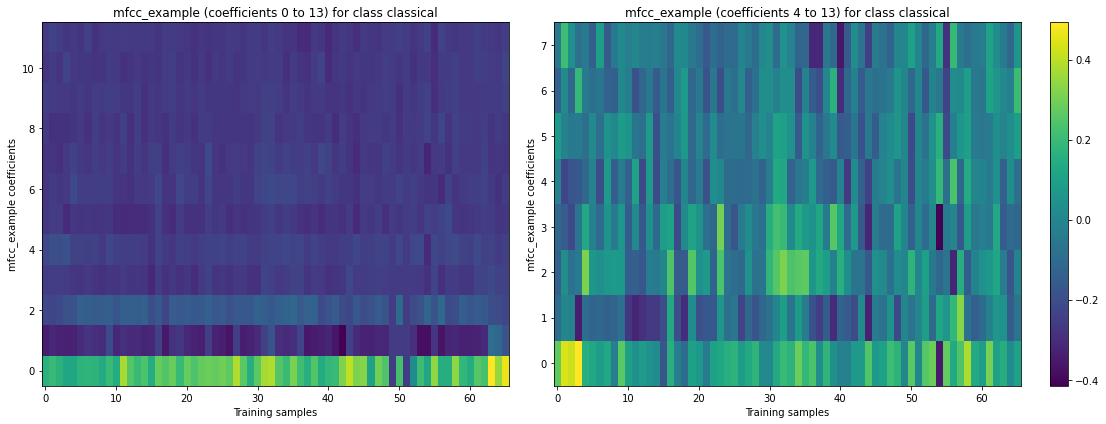

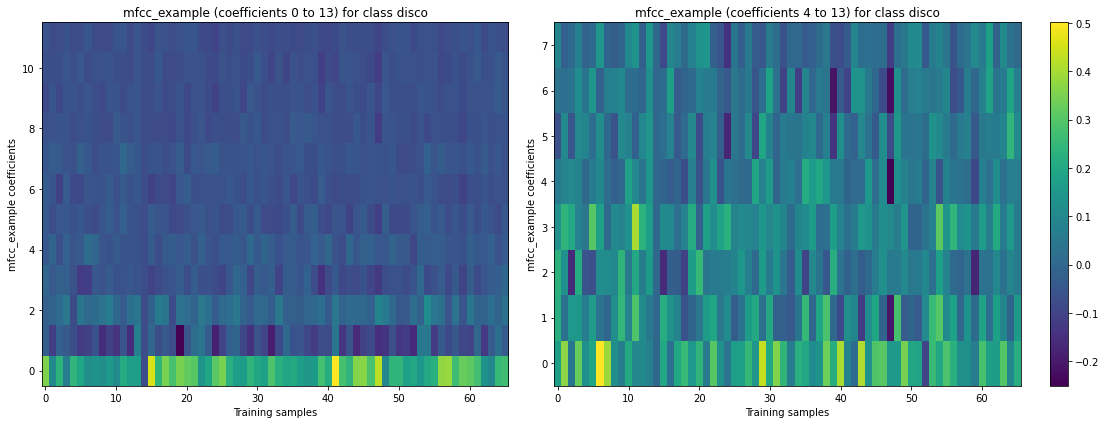

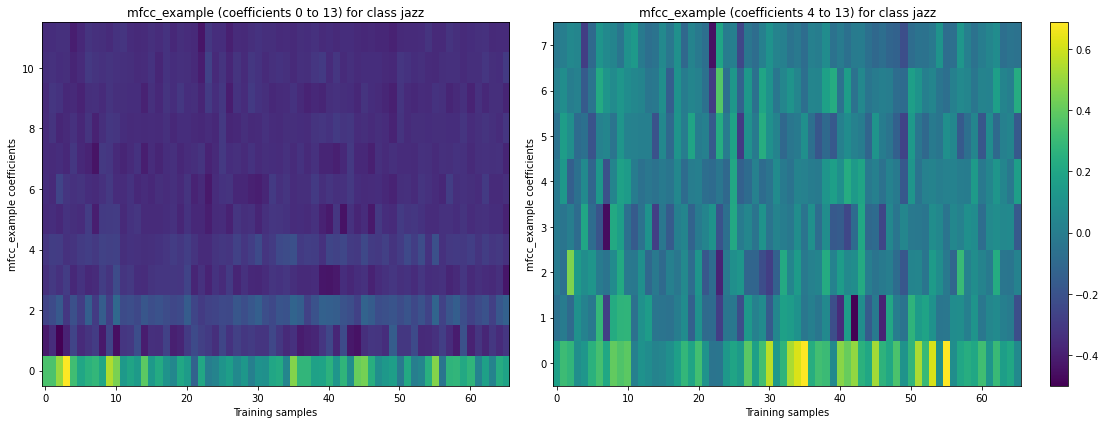

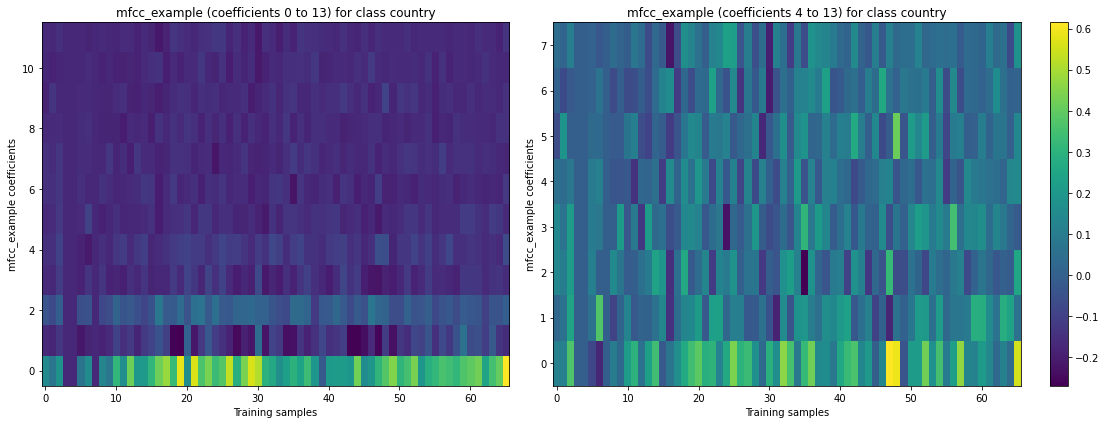

In [14]:
# Time to visualize our input features
for c in classes:
    mfcc_example = dict_train_features_mfcc_svm[c].transpose()
    
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc_example, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('mfcc_example coefficients')
    plt.title('mfcc_example (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_example_upper = mfcc_example[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_example_upper, origin='lower', aspect='auto')
    plt.title('mfcc_example (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('mfcc_example coefficients')
    plt.colorbar()
    plt.tight_layout()

[Text(0.5, 1.0, 'Chromagram for test files, classical')]

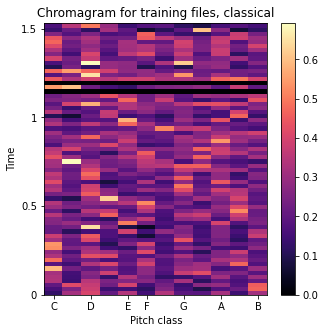

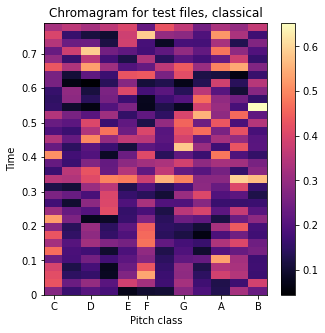

In [15]:
plt.rcParams['figure.figsize'] = [5, 5];
fig, ax = plt.subplots()
img = librosa.display.specshow(dict_train_features_chroma_svm['classical'], y_axis='time', x_axis='chroma', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram for training files, classical')

fig, ax = plt.subplots()
img = librosa.display.specshow(dict_test_features_chroma_svm['classical'], y_axis='time', x_axis='chroma', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram for test files, classical')


Text(0.5, 1.0, 'Mean of chroma features for disco')

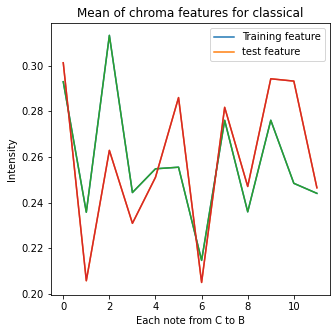

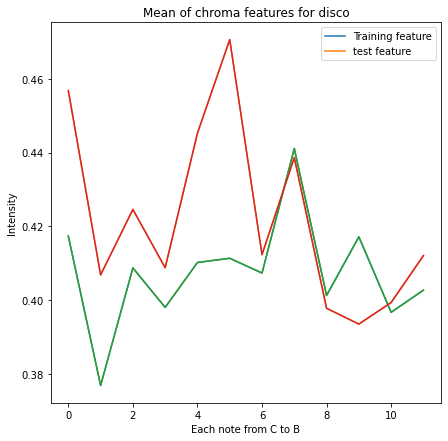

In [16]:
plt.figure(11)
plt.rcParams['figure.figsize'] = [7, 7];
plt.plot(np.mean(dict_train_features_chroma_svm['classical'],0))
plt.plot(np.mean(dict_test_features_chroma_svm['classical'],0))
plt.xlabel('Each note from C to B')
plt.ylabel('Intensity')
plt.legend(('Training feature', 'test feature'))
plt.title('Mean of chroma features for classical')

plt.figure(22)
plt.rcParams['figure.figsize'] = [7, 7];
plt.plot(np.mean(dict_train_features_chroma_svm['disco'],0))
plt.plot(np.mean(dict_test_features_chroma_svm['disco'],0))
plt.xlabel('Each note from C to B')
plt.ylabel('Intensity')
plt.legend(('Training feature', 'test feature'))
plt.title('Mean of chroma features for classical')


plt.figure(11)
plt.rcParams['figure.figsize'] = [7, 7];
plt.plot(np.mean(dict_train_features_chroma_svm['classical'],0))
plt.plot(np.mean(dict_test_features_chroma_svm['classical'],0))
plt.xlabel('Each note from C to B')
plt.ylabel('Intensity')
plt.legend(('Training feature', 'test feature'))
plt.title('Mean of chroma features for classical')

plt.figure(22)
plt.rcParams['figure.figsize'] = [7, 7];
plt.plot(np.mean(dict_train_features_chroma_svm['disco'],0))
plt.plot(np.mean(dict_test_features_chroma_svm['disco'],0))
plt.xlabel('Each note from C to B')
plt.ylabel('Intensity')
plt.legend(('Training feature', 'test feature'))
plt.title('Mean of chroma features for disco')


Text(0.5, 1.0, 'Spectral Roll Off')

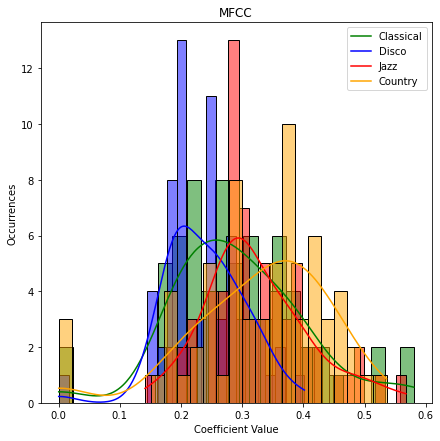

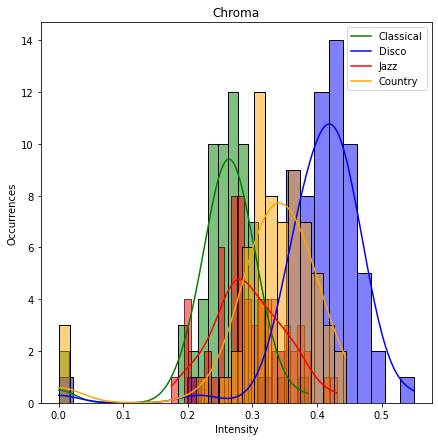

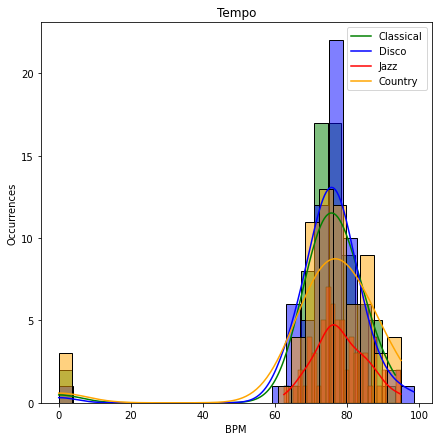

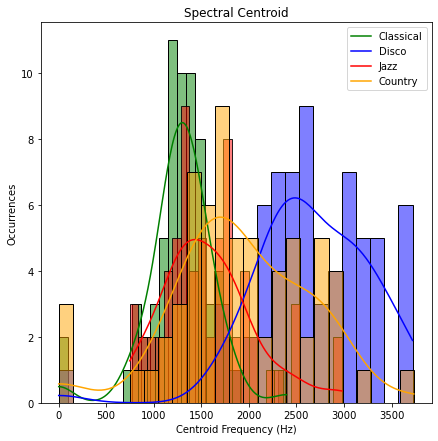

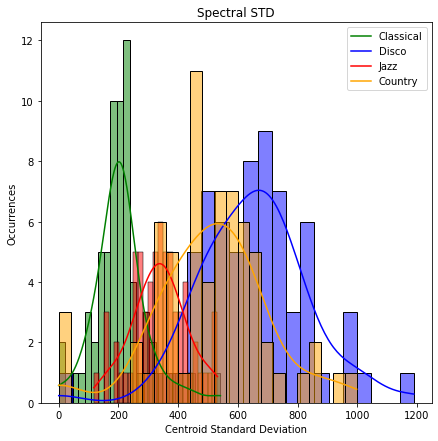

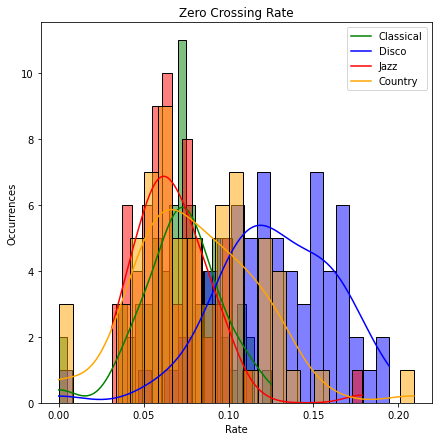

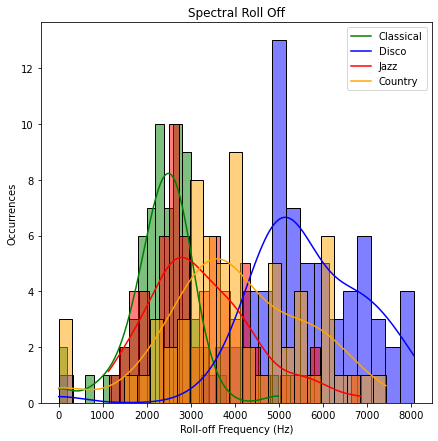

In [17]:
import seaborn as sns
plt.figure(1)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(np.mean(dict_train_features_mfcc_svm['classical'],1), color='green', bins=25, kde=True)
sns.histplot(np.mean(dict_train_features_mfcc_svm['disco'],1), color='blue', bins=25, kde=True)
sns.histplot(np.mean(dict_train_features_mfcc_svm['jazz'],1), color='red', bins=25, kde=True)
sns.histplot(np.mean(dict_train_features_mfcc_svm['country'],1), color='orange', bins=25, kde=True)
plt.xlabel('Coefficient Value')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('MFCC')
plt.figure(2)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(np.mean(dict_train_features_chroma_svm['classical'],1), color='green', bins=25, kde=True)
sns.histplot(np.mean(dict_train_features_chroma_svm['disco'],1), color='blue', bins=25, kde=True)
sns.histplot(np.mean(dict_train_features_chroma_svm['jazz'],1), color='red', bins=25, kde=True)
sns.histplot(np.mean(dict_train_features_chroma_svm['country'],1), color='orange', bins=25, kde=True)
plt.xlabel('Intensity')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('Chroma')
plt.figure(3)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(dict_train_features_tempo_svm['classical'][:,0], color='green', bins=25, kde=True)
sns.histplot(dict_train_features_tempo_svm['disco'][:,0], color='blue', bins=25, kde=True)
sns.histplot(dict_train_features_tempo_svm['jazz'][:,0], color='red', bins=25, kde=True)
sns.histplot(dict_train_features_tempo_svm['country'][:,0], color='orange', bins=25, kde=True)
plt.xlabel('BPM')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('Tempo')
plt.figure(4)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(dict_train_features_spectral_svm['classical'][:,0], color='green', bins=25, kde=True)
sns.histplot(dict_train_features_spectral_svm['disco'][:,0], color='blue', bins=25, kde=True)
sns.histplot(dict_train_features_spectral_svm['jazz'][:,0], color='red', bins=25, kde=True)
sns.histplot(dict_train_features_spectral_svm['country'][:,0], color='orange', bins=25, kde=True)
plt.xlabel('Centroid Frequency (Hz)')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('Spectral Centroid')
plt.figure(5)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(dict_train_features_spectral_std_svm['classical'][:,0], color='green', bins=25, kde=True)
sns.histplot(dict_train_features_spectral_std_svm['disco'][:,0], color='blue', bins=25, kde=True)
sns.histplot(dict_train_features_spectral_std_svm['jazz'][:,0], color='red', bins=25, kde=True)
sns.histplot(dict_train_features_spectral_std_svm['country'][:,0], color='orange', bins=25, kde=True)
plt.xlabel('Centroid Standard Deviation')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('Spectral STD')
plt.figure(6)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(dict_train_features_zcr_svm['classical'][:,0], color='green', bins=25, kde=True)
sns.histplot(dict_train_features_zcr_svm['disco'][:,0], color='blue', bins=25, kde=True)
sns.histplot(dict_train_features_zcr_svm['jazz'][:,0], color='red', bins=25, kde=True)
sns.histplot(dict_train_features_zcr_svm['country'][:,0], color='orange', bins=25, kde=True)
plt.xlabel('Rate')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('Zero Crossing Rate')
plt.figure(7)
plt.rcParams['figure.figsize'] = [7, 7];
sns.histplot(dict_train_features_specrolloff_svm['classical'][:,0], color='green', bins=25, kde=True)
sns.histplot(dict_train_features_specrolloff_svm['disco'][:,0], color='blue', bins=25, kde=True)
sns.histplot(dict_train_features_specrolloff_svm['jazz'][:,0], color='red', bins=25, kde=True)
sns.histplot(dict_train_features_specrolloff_svm['country'][:,0], color='orange', bins=25, kde=True)
plt.xlabel('Roll-off Frequency (Hz)')
plt.ylabel('Occurrences')
plt.legend(('Classical', 'Disco', 'Jazz','Country'))
plt.title('Spectral Roll Off')

**Testing the accuracy for all features:**

In [18]:
[y_test_mfcc, y_test_predicted_mv_mfcc] = svm_features(dict_train_features_mfcc_svm, dict_test_features_mfcc_svm)
[y_test_chroma, y_test_predicted_mv_chroma] = svm_features(dict_train_features_chroma_svm, dict_test_features_chroma_svm)
[y_test_tempo, y_test_predicted_mv_tempo] = svm_features(dict_train_features_tempo_svm, dict_test_features_tempo_svm)
[y_test_spectral, y_test_predicted_mv_spectral] = svm_features(dict_train_features_spectral_svm, dict_test_features_spectral_svm)
[y_test_spectral_std, y_test_predicted_mv_spectral_std] = svm_features(dict_train_features_spectral_std_svm, dict_test_features_spectral_std_svm)
[y_test_zcr, y_test_predicted_mv_zcr] = svm_features(dict_train_features_zcr_svm, dict_test_features_zcr_svm)
[y_test_specrolloff, y_test_predicted_mv_specrolloff] = svm_features(dict_train_features_specrolloff_svm, dict_test_features_specrolloff_svm)

[y_test_combined, y_test_predicted_mv_combined] = svm_features(dict_combined_train_features_svm, dict_combined_test_features_svm)

<ipython-input-11-9535f2823f37>:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test_predicted = np.array(y_test_predicted, dtype=np.int)
<ipython-input-11-9535f2823f37>:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depr

Text(0.5, 1.0, 'Confusion matrix using Combined metrics, as percentage')

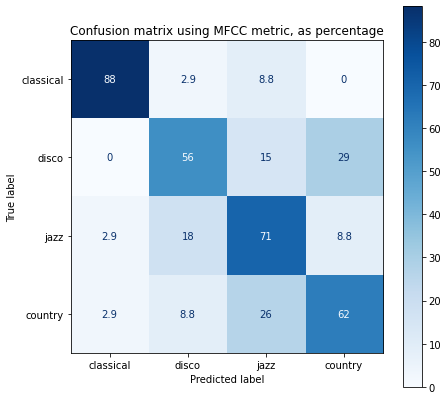

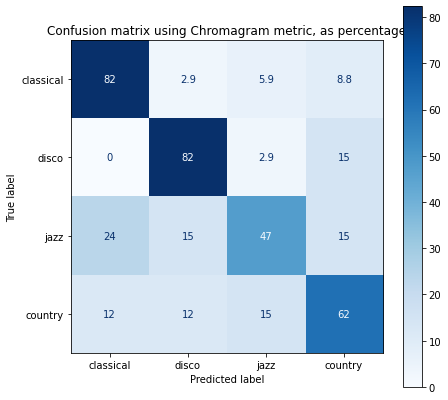

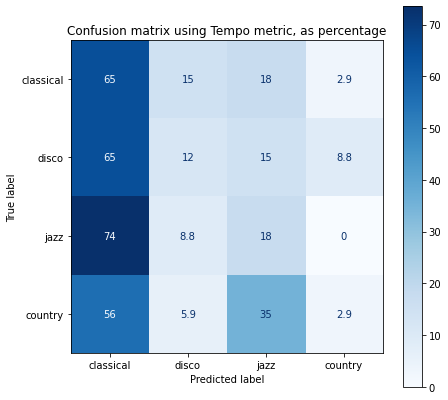

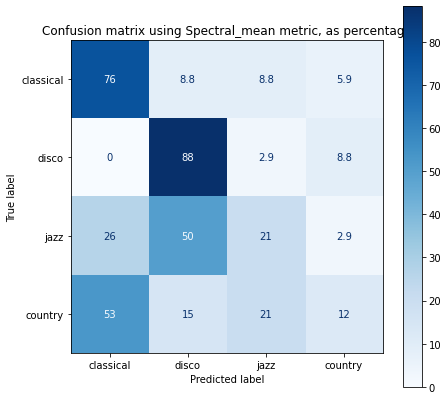

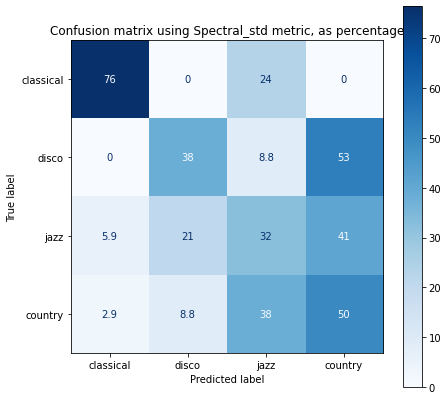

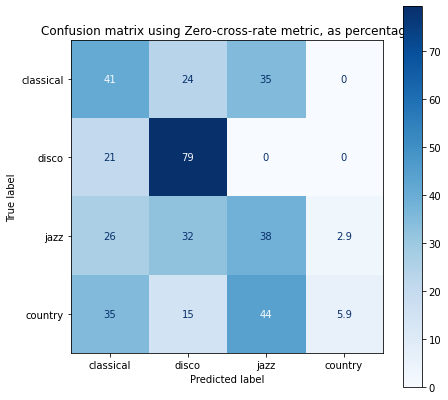

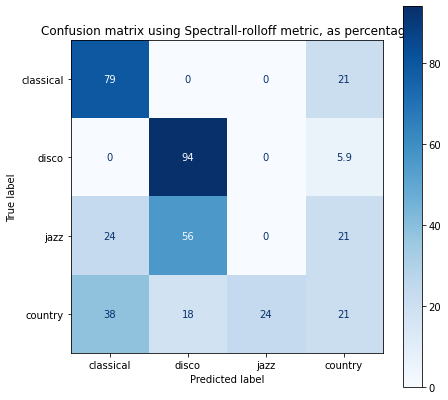

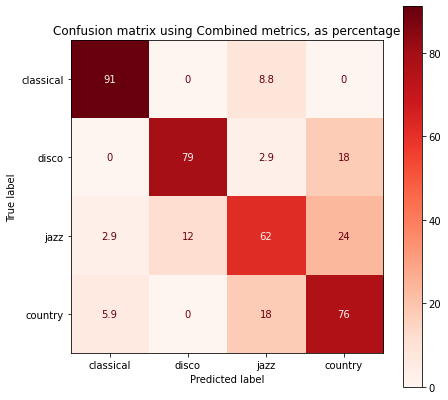

In [19]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm_mfcc = confusion_matrix(y_test_mfcc, y_test_predicted_mv_mfcc)/34*100           #normalized
cm_chroma = confusion_matrix(y_test_chroma, y_test_predicted_mv_chroma)/34*100     #normalized
cm_tempo = confusion_matrix(y_test_tempo, y_test_predicted_mv_tempo)/34*100        #normalized
cm_spectral = confusion_matrix(y_test_spectral, y_test_predicted_mv_spectral)/34*100             #normalized
cm_spectral_std = confusion_matrix(y_test_spectral_std, y_test_predicted_mv_spectral_std)/34*100 #normalized
cm_zcr = confusion_matrix(y_test_zcr, y_test_predicted_mv_zcr)/34*100              #normalized
cm_specrolloff = confusion_matrix(y_test_specrolloff, y_test_predicted_mv_specrolloff)/34*100    #normalized
cm_combined = confusion_matrix(y_test_combined, y_test_predicted_mv_combined)/34*100    #normalized


classlist = ['classical', 'disco', 'jazz', 'country']
disp = ConfusionMatrixDisplay(confusion_matrix = cm_mfcc, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using MFCC metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_chroma, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using Chromagram metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_tempo, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using Tempo metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_spectral, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using Spectral_mean metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_spectral_std, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using Spectral_std metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_zcr, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using Zero-cross-rate metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_specrolloff, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix using Spectrall-rolloff metric, as percentage")

disp = ConfusionMatrixDisplay(confusion_matrix = cm_combined, display_labels = classlist)
disp.plot(cmap = 'Reds')
disp.ax_.set_title("Confusion matrix using Combined metrics, as percentage")

**More evaluation reports**

In [20]:
# Evaluation

report_val_mfcc = sklearn.metrics.classification_report(y_test_mfcc, y_test_predicted_mv_mfcc, target_names = None)
report_val_chroma= sklearn.metrics.classification_report(y_test_chroma, y_test_predicted_mv_chroma, target_names = None)
report_val_tempo = sklearn.metrics.classification_report(y_test_tempo, y_test_predicted_mv_tempo, target_names = None)
report_val_spectral = sklearn.metrics.classification_report(y_test_spectral, y_test_predicted_mv_spectral, target_names = None)
report_val_spectral_std = sklearn.metrics.classification_report(y_test_spectral_std, y_test_predicted_mv_spectral_std, target_names = None)
report_val_zcr = sklearn.metrics.classification_report(y_test_zcr, y_test_predicted_mv_zcr, target_names = None)
report_val_specrolloff = sklearn.metrics.classification_report(y_test_specrolloff, y_test_predicted_mv_specrolloff, target_names = None)
report_val_combined = sklearn.metrics.classification_report(y_test_combined, y_test_predicted_mv_combined, target_names = None)

print("Evaluation table using MFCC metric\n")
print(report_val_mfcc)
print("Evaluation table using Chromagram metric\n")
print(report_val_chroma)
print("Evaluation table using Tempo metric\n")
print(report_val_tempo)
print("Evaluation table using Spectral_Mean metric\n")
print(report_val_spectral)
print("Evaluation table using Spectral_STD metric\n")
print(report_val_spectral_std)
print("Evaluation table using Zero-Cross-Rate metric\n")
print(report_val_zcr)
print("Evaluation table using Zero-Cross-Rate metric\n")
print(report_val_specrolloff)
print("Evaluation table using Combined metrics\n")
print(report_val_combined)

Evaluation table using MFCC metric

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91        34
         1.0       0.66      0.56      0.60        34
         2.0       0.59      0.71      0.64        34
         3.0       0.62      0.62      0.62        34

    accuracy                           0.69       136
   macro avg       0.70      0.69      0.69       136
weighted avg       0.70      0.69      0.69       136

Evaluation table using Chromagram metric

              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76        34
         1.0       0.74      0.82      0.78        34
         2.0       0.67      0.47      0.55        34
         3.0       0.62      0.62      0.62        34

    accuracy                           0.68       136
   macro avg       0.68      0.68      0.68       136
weighted avg       0.68      0.68      0.68       136

Evaluation table using Tempo metric

              p

Bar plot for accuracies of all eight methods with SVM module


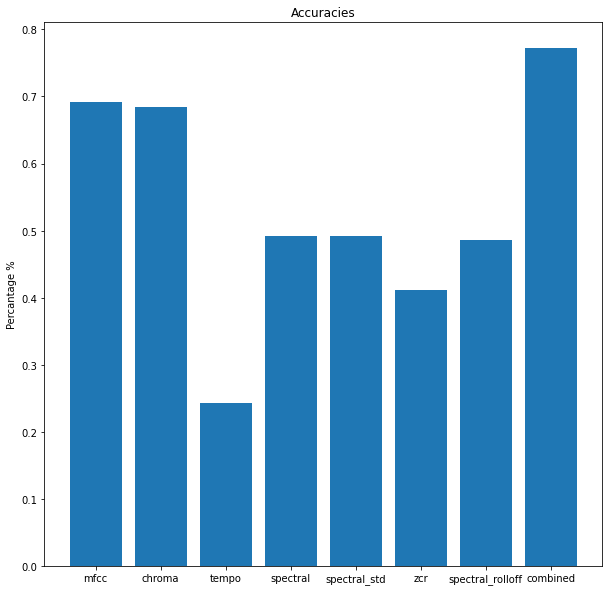

In [21]:
n_features = 8;
accuracy = np.zeros(shape = n_features);

accuracy[0] = sklearn.metrics.accuracy_score(y_test_mfcc, y_test_predicted_mv_mfcc, normalize=True, sample_weight=None)
accuracy[1] = sklearn.metrics.accuracy_score(y_test_chroma, y_test_predicted_mv_chroma, normalize=True, sample_weight=None)
accuracy[2] = sklearn.metrics.accuracy_score(y_test_tempo, y_test_predicted_mv_tempo, normalize=True, sample_weight=None)
accuracy[3] = sklearn.metrics.accuracy_score(y_test_spectral, y_test_predicted_mv_spectral, normalize=True, sample_weight=None)
accuracy[4] = sklearn.metrics.accuracy_score(y_test_spectral_std, y_test_predicted_mv_spectral_std, normalize=True, sample_weight=None)
accuracy[5] = sklearn.metrics.accuracy_score(y_test_zcr, y_test_predicted_mv_zcr, normalize=True, sample_weight=None)
accuracy[6] = sklearn.metrics.accuracy_score(y_test_specrolloff, y_test_predicted_mv_specrolloff, normalize=True, sample_weight=None)
accuracy[7] = sklearn.metrics.accuracy_score(y_test_combined, y_test_predicted_mv_combined, normalize=True, sample_weight=None)

feat_names = ["mfcc","chroma","tempo","spectral","spectral_std","zcr","spectral_rolloff","combined"]

plt.rcParams['figure.figsize'] = [10, 10];
print("Bar plot for accuracies of all eight methods with SVM module")
plt.bar(feat_names,accuracy)
plt.title("Accuracies")
plt.ylabel('Percantage %')
plt.show()

**Training the CNN model**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

class_0 = 'classical'
class_1 = 'disco'
class_2 = 'jazz'
class_3 = 'country'

x_train_0 = dict_train_features[class_0]
x_train_1 = dict_train_features[class_1]
x_train_2 = dict_train_features[class_2]
x_train_3 = dict_train_features[class_3]

#Normalization protocol
feat_max = np.max(np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3), axis=0), axis=0)
feat_min = np.min(np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3), axis=0), axis=0)

x_train_0_normalized = (x_train_0 - feat_min) / (feat_max - feat_min)
x_train_1_normalized = (x_train_1 - feat_min) / (feat_max - feat_min)
x_train_2_normalized = (x_train_2 - feat_min) / (feat_max - feat_min)
x_train_3_normalized = (x_train_3 - feat_min) / (feat_max - feat_min)

x_train = np.concatenate((x_train_0_normalized, x_train_1_normalized, x_train_2_normalized, x_train_3_normalized), axis=0)

x_test_0 = dict_test_features[class_0]
x_test_1 = dict_test_features[class_1]
x_test_2 = dict_test_features[class_2]
x_test_3 = dict_test_features[class_3]

x_test_0_normalized = (x_test_0 - feat_min) / (feat_max - feat_min)
x_test_1_normalized = (x_test_1 - feat_min) / (feat_max - feat_min)
x_test_2_normalized = (x_test_2 - feat_min) / (feat_max - feat_min)
x_test_3_normalized = (x_test_3 - feat_min) / (feat_max - feat_min)

x_test = np.concatenate((x_test_0_normalized, x_test_1_normalized, x_test_2_normalized, x_test_3_normalized), axis=0)
###

y_train_0 = np.zeros((x_train_0.shape[0],))
y_train_1 = np.ones((x_train_1.shape[0],))
y_train_2 = np.ones((x_train_2.shape[0],))*2
y_train_3 = np.ones((x_train_3.shape[0],))*3

y_train = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3), axis=0)

y_test_0 = np.zeros((x_test_0.shape[0],))
y_test_1 = np.ones((x_test_1.shape[0],))
y_test_2 = np.ones((x_test_2.shape[0],))*2
y_test_3 = np.ones((x_test_3.shape[0],))*3

y_test = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)

#Splitting up the training data into training and validation!
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle= True)

input_shape=(x_train.shape[1], x_train.shape[2],1)
print('Input shape',input_shape)

# Specifying the model architecture
model = tf.keras.models.Sequential()

# First convolutional layer 
model.add(tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization())

#2nd convolutional layer
model.add(tf.keras.layers.Conv2D(16, (2,2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

#3rd convolutional layer
model.add(tf.keras.layers.Conv2D(16, (2,2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

#flatting and the dense layer
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

#output layer
model.add(tf.keras.layers.Dense(4,activation='softmax'))
model.summary()

adamopt = tf.keras.optimizers.Adam(learning_rate = 0.001)
epochs = 300

#decay_rate = learning_rate / epochs
#momentum = 0.8
#sgd = tf.keras.optimizers.Adam(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(optimizer = adamopt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

x_train = np.expand_dims(x_train, axis=3)
x_val = np.expand_dims(x_val, axis=3)

print(np.shape(x_train))
#from tensorflow.keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min')
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size = 32, epochs = epochs)#,callbacks=[es])

Input shape (15, 29, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 27, 4)         40        
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 27, 4)         16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 26, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 26, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 25, 16)        1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 25, 16)        64        
_________________________________________________________________
global_average_pooling2d (Gl (No

Epoch 47/300
7/7 [==============================] - 0s 55ms/step - loss: 1.1186 - accuracy: 0.5455 - val_loss: 1.2443 - val_accuracy: 0.5455
Epoch 48/300
7/7 [==============================] - 0s 56ms/step - loss: 1.1124 - accuracy: 0.5707 - val_loss: 1.2436 - val_accuracy: 0.5606
Epoch 49/300
7/7 [==============================] - 0s 62ms/step - loss: 1.1412 - accuracy: 0.5455 - val_loss: 1.2233 - val_accuracy: 0.5455
Epoch 50/300
7/7 [==============================] - 1s 80ms/step - loss: 1.0991 - accuracy: 0.5859 - val_loss: 1.2115 - val_accuracy: 0.5455
Epoch 51/300
7/7 [==============================] - 0s 58ms/step - loss: 1.1199 - accuracy: 0.5556 - val_loss: 1.1949 - val_accuracy: 0.5758
Epoch 52/300
7/7 [==============================] - 0s 59ms/step - loss: 1.1243 - accuracy: 0.5505 - val_loss: 1.1884 - val_accuracy: 0.5455
Epoch 53/300
7/7 [==============================] - 0s 68ms/step - loss: 1.1080 - accuracy: 0.5657 - val_loss: 1.1943 - val_accuracy: 0.5606
Epoch 54/300


7/7 [==============================] - 0s 60ms/step - loss: 1.0061 - accuracy: 0.6061 - val_loss: 1.0183 - val_accuracy: 0.6212
Epoch 105/300
7/7 [==============================] - 0s 71ms/step - loss: 1.0444 - accuracy: 0.5556 - val_loss: 0.9984 - val_accuracy: 0.6515
Epoch 106/300
7/7 [==============================] - 0s 57ms/step - loss: 1.0282 - accuracy: 0.5505 - val_loss: 0.9907 - val_accuracy: 0.6515
Epoch 107/300
7/7 [==============================] - 1s 87ms/step - loss: 0.9841 - accuracy: 0.6212 - val_loss: 0.9999 - val_accuracy: 0.6515
Epoch 108/300
7/7 [==============================] - 0s 70ms/step - loss: 1.0030 - accuracy: 0.5707 - val_loss: 1.0111 - val_accuracy: 0.6667
Epoch 109/300
7/7 [==============================] - 1s 80ms/step - loss: 1.0355 - accuracy: 0.5354 - val_loss: 1.0164 - val_accuracy: 0.6061
Epoch 110/300
7/7 [==============================] - 1s 77ms/step - loss: 1.0047 - accuracy: 0.6061 - val_loss: 1.0188 - val_accuracy: 0.6061
Epoch 111/300
7/7 [=

Epoch 162/300
7/7 [==============================] - 0s 64ms/step - loss: 0.9260 - accuracy: 0.6212 - val_loss: 0.9312 - val_accuracy: 0.7424
Epoch 163/300
7/7 [==============================] - 0s 66ms/step - loss: 0.9245 - accuracy: 0.5909 - val_loss: 0.9415 - val_accuracy: 0.6970
Epoch 164/300
7/7 [==============================] - 0s 61ms/step - loss: 0.9196 - accuracy: 0.6263 - val_loss: 1.0108 - val_accuracy: 0.5909
Epoch 165/300
7/7 [==============================] - 0s 62ms/step - loss: 0.9074 - accuracy: 0.6162 - val_loss: 1.0025 - val_accuracy: 0.6061
Epoch 166/300
7/7 [==============================] - 0s 60ms/step - loss: 0.9533 - accuracy: 0.5808 - val_loss: 0.9740 - val_accuracy: 0.6212
Epoch 167/300
7/7 [==============================] - 0s 66ms/step - loss: 0.8924 - accuracy: 0.6414 - val_loss: 0.9428 - val_accuracy: 0.6515
Epoch 168/300
7/7 [==============================] - 0s 66ms/step - loss: 0.9458 - accuracy: 0.5808 - val_loss: 0.9720 - val_accuracy: 0.6667
Epoch 

Epoch 220/300
7/7 [==============================] - 0s 62ms/step - loss: 0.8264 - accuracy: 0.6919 - val_loss: 0.9960 - val_accuracy: 0.6515
Epoch 221/300
7/7 [==============================] - 0s 57ms/step - loss: 0.8391 - accuracy: 0.6667 - val_loss: 1.0023 - val_accuracy: 0.6212
Epoch 222/300
7/7 [==============================] - 0s 65ms/step - loss: 0.8558 - accuracy: 0.6717 - val_loss: 0.9267 - val_accuracy: 0.6667
Epoch 223/300
7/7 [==============================] - 0s 62ms/step - loss: 0.8364 - accuracy: 0.6465 - val_loss: 0.9312 - val_accuracy: 0.6970
Epoch 224/300
7/7 [==============================] - 0s 63ms/step - loss: 0.8490 - accuracy: 0.6263 - val_loss: 0.9578 - val_accuracy: 0.6212
Epoch 225/300
7/7 [==============================] - 0s 64ms/step - loss: 0.9118 - accuracy: 0.6364 - val_loss: 0.9409 - val_accuracy: 0.6970
Epoch 226/300
7/7 [==============================] - 0s 62ms/step - loss: 0.8706 - accuracy: 0.6515 - val_loss: 0.9139 - val_accuracy: 0.6818
Epoch 

7/7 [==============================] - 0s 69ms/step - loss: 0.8498 - accuracy: 0.6263 - val_loss: 0.9420 - val_accuracy: 0.6515
Epoch 278/300
7/7 [==============================] - 0s 66ms/step - loss: 0.8016 - accuracy: 0.6919 - val_loss: 0.9168 - val_accuracy: 0.6970
Epoch 279/300
7/7 [==============================] - 0s 64ms/step - loss: 0.7432 - accuracy: 0.7121 - val_loss: 0.9205 - val_accuracy: 0.6818
Epoch 280/300
7/7 [==============================] - 0s 63ms/step - loss: 0.8337 - accuracy: 0.6515 - val_loss: 0.9272 - val_accuracy: 0.6818
Epoch 281/300
7/7 [==============================] - 1s 71ms/step - loss: 0.7963 - accuracy: 0.6566 - val_loss: 0.9105 - val_accuracy: 0.6364
Epoch 282/300
7/7 [==============================] - 1s 100ms/step - loss: 0.8296 - accuracy: 0.6768 - val_loss: 0.9814 - val_accuracy: 0.6818
Epoch 283/300
7/7 [==============================] - 1s 98ms/step - loss: 0.8331 - accuracy: 0.6414 - val_loss: 3.2408 - val_accuracy: 0.2576
Epoch 284/300
7/7 [

**Plotting the history of the training**

Best validation accuracy:  0.7424242496490479


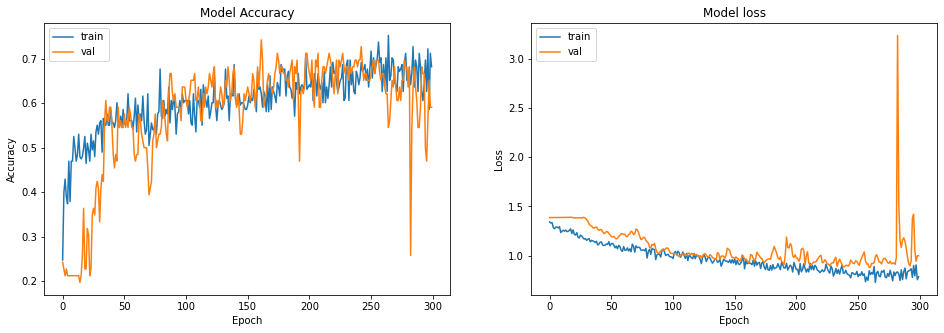

In [23]:
best_acc = np.max(history.history['val_accuracy'])
print('Best validation accuracy: ', best_acc)

plt.figure(figsize = (16,5))
plt.subplot(1,2,1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'])

plt.subplot(1,2,2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])

Test score: 0.8922771215438843
Test accuracy: 0.6764705777168274
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 1 1 3
 3 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 0 2 2 2 2 3
 2 1 3 1 3 3 2 3 3 1 1 1 1 1 3 1 3 1 0 3 3 3 3 2 3 2 2 2 0 3 1 3 3 3 3 3 3
 3 1 0 3 3 3 1 3 3 1 3 1 3 3 1 1 3 1 3 3 3 3 3 3 1]


Text(0.5, 1.0, 'Confusion matrix of CNN, as percentage')

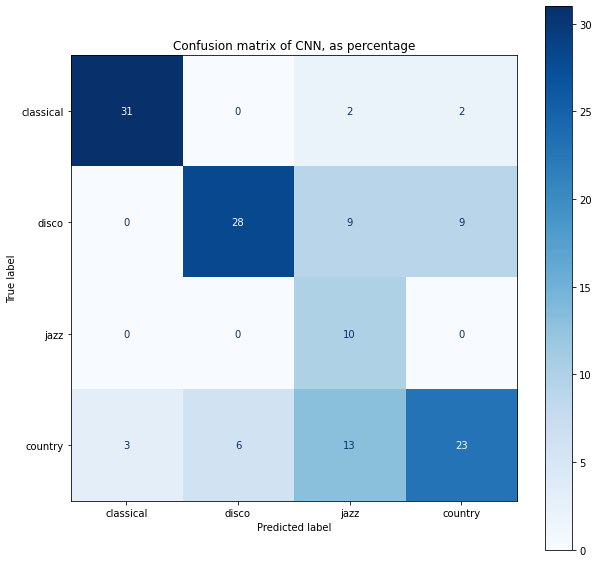

In [24]:
x_test_rs = np.expand_dims(x_test, axis=3)
score, acc = model.evaluate(x_test_rs, y_test, batch_size=32,verbose=0);
print('Test score:', score)
print('Test accuracy:', acc)
y_pred = model.predict(x_test_rs)
pred_val = np.argmax(y_pred, axis=1)

print(pred_val)
cm = confusion_matrix(pred_val, y_test)           #normalized
classlist = ['classical', 'disco', 'jazz', 'country']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix of CNN, as percentage")

In [25]:
report_val_cnn = sklearn.metrics.classification_report(y_test, pred_val, target_names = None)

print(report_val_cnn)

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90        34
         1.0       0.61      0.82      0.70        34
         2.0       1.00      0.29      0.45        34
         3.0       0.51      0.68      0.58        34

    accuracy                           0.68       136
   macro avg       0.75      0.68      0.66       136
weighted avg       0.75      0.68      0.66       136



**Training the CNN model with PCA data**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

class_0 = 'classical'
class_1 = 'disco'
class_2 = 'jazz'
class_3 = 'country'


### Normalization protocol

feat_max = np.max(PCA_feature_table, axis=0)
feat_min = np.min(PCA_feature_table, axis=0)

PCA_feature_table_normalized = (PCA_feature_table - feat_min) / (feat_max - feat_min)

feat_max = np.max(PCA_feature_table_test, axis=0)
feat_min = np.min(PCA_feature_table_test, axis=0)

PCA_feature_table_test_normalized = (PCA_feature_table_test - feat_min) / (feat_max - feat_min)

###

class_size = int(np.size(PCA_feature_table,0)/4)

y_train_0 = np.zeros((class_size,))
y_train_1 = np.ones((class_size,))
y_train_2 = np.ones((class_size,))*2
y_train_3 = np.ones((class_size,))*3

y_train = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3), axis=0)

class_size_test = int(np.size(PCA_feature_table_test,0)/4)

y_test_0 = np.zeros((class_size_test,))
y_test_1 = np.ones((class_size_test,))
y_test_2 = np.ones((class_size_test,))*2
y_test_3 = np.ones((class_size_test,))*3

y_test = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)

x_train, x_val, y_train, y_val = train_test_split(PCA_feature_table_normalized, y_train, test_size=0.25, shuffle= True)

input_shape=(x_train.shape[1], x_train.shape[2],1)
print('Input shape',input_shape)

model = tf.keras.models.Sequential()

# First convolutional layer 
model.add(tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization())

#2nd convolutional layer
model.add(tf.keras.layers.Conv2D(16, (2,2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

#3rd convolutional layer
model.add(tf.keras.layers.Conv2D(16, (2,2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

#flatting and the dense layer
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

#output layer
model.add(tf.keras.layers.Dense(4,activation='softmax'))
model.summary()

adamopt = tf.keras.optimizers.Adam(learning_rate = 0.001)
epochs = 300

model.compile(optimizer = adamopt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

x_train = np.expand_dims(x_train, axis=3)
x_val = np.expand_dims(x_val, axis=3)

history = model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size = 32, epochs = epochs)

Input shape (15, 10, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 8, 4)          40        
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 8, 4)          16        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 7, 16)         272       
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 7, 16)         64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 6, 16)         1040      
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 6, 16)         64        
_________________________________________________________________
global_average_pooling2d_1 ( (

7/7 [==============================] - 0s 34ms/step - loss: 1.2512 - accuracy: 0.4242 - val_loss: 1.3515 - val_accuracy: 0.2727
Epoch 47/300
7/7 [==============================] - 0s 35ms/step - loss: 1.2178 - accuracy: 0.4192 - val_loss: 1.3439 - val_accuracy: 0.3030
Epoch 48/300
7/7 [==============================] - 0s 33ms/step - loss: 1.2173 - accuracy: 0.4040 - val_loss: 1.3476 - val_accuracy: 0.3636
Epoch 49/300
7/7 [==============================] - 0s 40ms/step - loss: 1.2349 - accuracy: 0.4040 - val_loss: 1.3543 - val_accuracy: 0.3485
Epoch 50/300
7/7 [==============================] - 0s 34ms/step - loss: 1.2461 - accuracy: 0.4091 - val_loss: 1.3430 - val_accuracy: 0.3636
Epoch 51/300
7/7 [==============================] - 0s 35ms/step - loss: 1.2264 - accuracy: 0.3889 - val_loss: 1.3387 - val_accuracy: 0.3485
Epoch 52/300
7/7 [==============================] - 0s 30ms/step - loss: 1.1947 - accuracy: 0.4293 - val_loss: 1.3178 - val_accuracy: 0.3485
Epoch 53/300
7/7 [========

7/7 [==============================] - 0s 31ms/step - loss: 1.0886 - accuracy: 0.4848 - val_loss: 1.2686 - val_accuracy: 0.4091
Epoch 104/300
7/7 [==============================] - 0s 30ms/step - loss: 1.0720 - accuracy: 0.5253 - val_loss: 1.2653 - val_accuracy: 0.4091
Epoch 105/300
7/7 [==============================] - 0s 28ms/step - loss: 1.1254 - accuracy: 0.5000 - val_loss: 1.1449 - val_accuracy: 0.5303
Epoch 106/300
7/7 [==============================] - 0s 26ms/step - loss: 1.1008 - accuracy: 0.5303 - val_loss: 1.1611 - val_accuracy: 0.5303
Epoch 107/300
7/7 [==============================] - 0s 27ms/step - loss: 1.0785 - accuracy: 0.5000 - val_loss: 1.2505 - val_accuracy: 0.4545
Epoch 108/300
7/7 [==============================] - 0s 26ms/step - loss: 1.0466 - accuracy: 0.5202 - val_loss: 1.2866 - val_accuracy: 0.4242
Epoch 109/300
7/7 [==============================] - 0s 27ms/step - loss: 1.0466 - accuracy: 0.5202 - val_loss: 1.3019 - val_accuracy: 0.4242
Epoch 110/300
7/7 [=

7/7 [==============================] - 0s 48ms/step - loss: 0.9486 - accuracy: 0.5808 - val_loss: 1.2156 - val_accuracy: 0.5152
Epoch 161/300
7/7 [==============================] - 0s 33ms/step - loss: 0.9900 - accuracy: 0.5808 - val_loss: 1.2089 - val_accuracy: 0.5000
Epoch 162/300
7/7 [==============================] - 0s 34ms/step - loss: 0.9778 - accuracy: 0.5354 - val_loss: 1.2617 - val_accuracy: 0.4242
Epoch 163/300
7/7 [==============================] - 0s 44ms/step - loss: 0.9556 - accuracy: 0.5758 - val_loss: 1.3455 - val_accuracy: 0.4242
Epoch 164/300
7/7 [==============================] - 0s 37ms/step - loss: 0.9666 - accuracy: 0.5758 - val_loss: 1.5752 - val_accuracy: 0.4242
Epoch 165/300
7/7 [==============================] - 0s 38ms/step - loss: 0.9763 - accuracy: 0.5404 - val_loss: 1.3718 - val_accuracy: 0.4394
Epoch 166/300
7/7 [==============================] - 0s 33ms/step - loss: 0.9334 - accuracy: 0.5758 - val_loss: 1.2111 - val_accuracy: 0.5000
Epoch 167/300
7/7 [=

7/7 [==============================] - 0s 30ms/step - loss: 0.9312 - accuracy: 0.5909 - val_loss: 1.4694 - val_accuracy: 0.4545
Epoch 218/300
7/7 [==============================] - 0s 31ms/step - loss: 0.8602 - accuracy: 0.6263 - val_loss: 1.2112 - val_accuracy: 0.4697
Epoch 219/300
7/7 [==============================] - 0s 31ms/step - loss: 0.9350 - accuracy: 0.5808 - val_loss: 1.2409 - val_accuracy: 0.5152
Epoch 220/300
7/7 [==============================] - 0s 28ms/step - loss: 0.9361 - accuracy: 0.5556 - val_loss: 1.6076 - val_accuracy: 0.3788
Epoch 221/300
7/7 [==============================] - 0s 31ms/step - loss: 0.9156 - accuracy: 0.5909 - val_loss: 1.6172 - val_accuracy: 0.4091
Epoch 222/300
7/7 [==============================] - 0s 22ms/step - loss: 0.8662 - accuracy: 0.5960 - val_loss: 1.4542 - val_accuracy: 0.4697
Epoch 223/300
7/7 [==============================] - 0s 22ms/step - loss: 0.8927 - accuracy: 0.6162 - val_loss: 1.3323 - val_accuracy: 0.4697
Epoch 224/300
7/7 [=

7/7 [==============================] - 0s 25ms/step - loss: 0.8458 - accuracy: 0.6212 - val_loss: 1.3081 - val_accuracy: 0.5303
Epoch 275/300
7/7 [==============================] - 0s 23ms/step - loss: 0.8924 - accuracy: 0.5960 - val_loss: 1.2887 - val_accuracy: 0.5303
Epoch 276/300
7/7 [==============================] - 0s 26ms/step - loss: 0.8240 - accuracy: 0.6162 - val_loss: 1.6288 - val_accuracy: 0.3939
Epoch 277/300
7/7 [==============================] - 0s 28ms/step - loss: 0.9182 - accuracy: 0.5505 - val_loss: 1.9095 - val_accuracy: 0.3636
Epoch 278/300
7/7 [==============================] - 0s 28ms/step - loss: 0.8874 - accuracy: 0.5909 - val_loss: 1.5318 - val_accuracy: 0.4545
Epoch 279/300
7/7 [==============================] - 0s 22ms/step - loss: 0.8410 - accuracy: 0.6010 - val_loss: 1.4499 - val_accuracy: 0.4697
Epoch 280/300
7/7 [==============================] - 0s 21ms/step - loss: 0.7919 - accuracy: 0.6616 - val_loss: 1.4000 - val_accuracy: 0.4697
Epoch 281/300
7/7 [=

**Plotting the history of training and other results**

Best validation accuracy:  0.5757575631141663


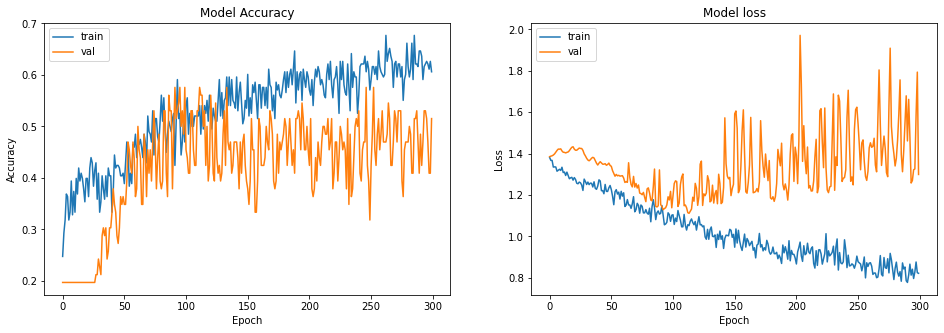

In [27]:
best_acc = np.max(history.history['val_accuracy'])
print('Best validation accuracy: ', best_acc)

plt.figure(figsize = (16,5))
plt.subplot(1,2,1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'])

plt.subplot(1,2,2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])

Test score: 1.3385220766067505
Test accuracy: 0.47058823704719543
[0 0 3 0 0 0 0 0 0 0 2 0 0 3 3 0 3 3 3 3 3 0 0 0 0 0 0 3 0 0 0 2 1 0 3 2 1
 0 1 1 0 1 3 2 3 1 1 1 2 0 1 1 1 1 3 1 2 3 3 3 2 0 3 3 1 1 1 1 0 2 0 2 2 0
 0 3 2 3 0 3 0 2 1 1 1 1 3 3 0 3 0 0 0 0 0 0 0 0 0 0 2 3 2 0 3 2 3 0 2 3 3
 3 3 3 0 2 3 3 2 3 3 3 3 0 3 2 3 0 3 2 3 2 3 3 3 1]


Text(0.5, 1.0, 'Confusion matrix of CNN using PCA data, as percentage')

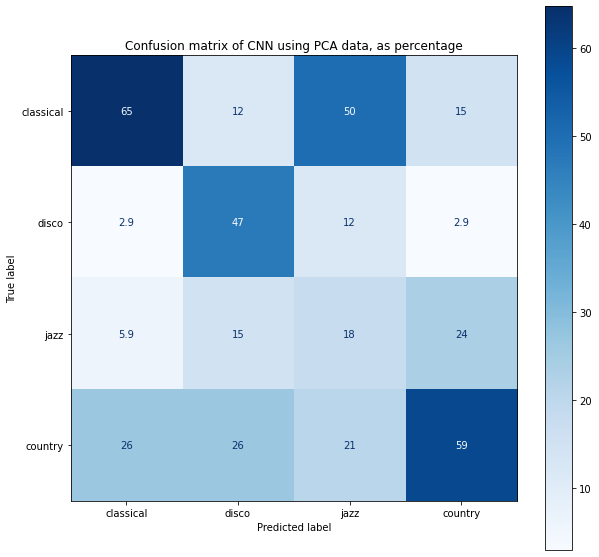

In [28]:
x_test = PCA_feature_table_test_normalized
x_test_rs = np.expand_dims(x_test, axis=3)
score, acc = model.evaluate(x_test_rs, y_test, batch_size=32,verbose=0);
print('Test score:', score)
print('Test accuracy:', acc)
y_pred = model.predict(x_test_rs)
pred_val = np.argmax(y_pred, axis=1)
print(pred_val)
cm = confusion_matrix(pred_val, y_test)/34*100           #normalized
classlist = ['classical', 'disco', 'jazz', 'country']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classlist)
disp.plot(cmap = 'Blues')
disp.ax_.set_title("Confusion matrix of CNN using PCA data, as percentage")


In [29]:
report_val_pca_cnn = sklearn.metrics.classification_report(y_test, pred_val, target_names = None)

print("Evaluation table using MFCC metric\n")
print(report_val_pca_cnn)

Evaluation table using MFCC metric

              precision    recall  f1-score   support

         0.0       0.46      0.65      0.54        34
         1.0       0.73      0.47      0.57        34
         2.0       0.29      0.18      0.22        34
         3.0       0.44      0.59      0.51        34

    accuracy                           0.47       136
   macro avg       0.48      0.47      0.46       136
weighted avg       0.48      0.47      0.46       136

